<a href="https://colab.research.google.com/github/fire-classifying/fireclass/blob/master/Proyecto_Incendios_v_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Predicción tipo de Incendios

Dividimos el análisis en los siguientes apartados:


<b>1. Introducción. Comprender el problema</b>

<b>2. Analítica exploratoria y preparación de datos</b>

<b>3. Estudio de variables:</b>

  * Estudio univariable
  * Estudio multivariable
 
<b>4. Tratamiento de los datos</b>

<b>5. Selección del modelo Machine Learning<b/> 
    
<b>6. Medición de Rendimiento de Modelos</b>



In [1]:
# Ejecuta esta celda para activar tu cuenta de Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 1. Introducción

En este proyecto se tratará de predecir el tipo de incendio que se va a generar (conato, incendio o gran incendio) a partir de distintos factores físicos, como el (clima, relieve, tipo de vegetación, humedad de la vegetación,etc), con el fin de que los equipos de extinción puedan priorizar sus recursos en función del tipo de incendio que se pueden encuentrar. De hecho, la franja horaria para atajar un incendio son las primeras horas, con lo que si se conoce el tipo de peligro de incendio que se puede generar, con una buena actuación a primera hora, ese incendio se puede atajar, y así evitar males mayores... Ya que tenemos que elaborar la base de datos extrayendo métricas de imágenes de satélite (Landsat y Modis).

Definición de qué es conato, incendio o gran incendio:

https://civio.es/espana-en-llamas/incendios-y-hectareas-quemadas/

El término <b>incendio</b> se usa de forma indiscriminada para referirse a cualquier siniestro provocado por el fuego. La Estadística General de Incendios Forestales (EGIF) del Ministerio distingue los siguientes tipos según la extensión de suelo afectada:

* <b>Conato:</b> siniestros que afectan a una superficie inferior a una hectárea.
* <b>Incendio:</b> todo fuego igual o superior a una hectárea.
* <b>Gran Incendio Forestal (GIF):</b> subtipo de incendio. Reciben esta denominación cuando el área quemada es igual o superior a 500 hectáreas.

Las hectáreas quemadas las tenemos, pero creemos que es mucho más difícil predecir las hectáreas que el tipo de categoría que tendrá el incendio...


### Variables del dataset:
    
* <b>ID</b>: Identificador del incendio
* <b>Año</b>: 
* <b>Fecha</b>:
* <b>Superficie quemada</b>: Siempre será mayor de 10 hectáreas
* <b>Superficie arbolada</b>: hectáreas de la superficie de árbol
* <b>Superficie pastizal</b>: Hectáreas de superficie pasto
* <b>Superficie Matorral</b>: Hectáreas de superficie matorral
* <b>W_arb</b>: peso arbolado quemado en tanto por uno
* <b>W_pasto</b>: Peso pasto quemado en tanto por uno
* <b>W_matorr</b>: Peso matorral quemado en tanto por
* <b>rk_Cuenca</b>:
* <b>rk_Hist_Cu</b>: Riesgo históricos en la cuenca
* <b>rk_Histo_us</b>: Riesgo histórico suceso****
* <b>rk_orograf</b>: en función de la pendiente
* <b>rk_peligro</b>: Zona peligro incendios
* <b>rk_pte</b>: Riesgo pendientes
* <b>Vuln_equip</b>: Vulnerabilidad por equipamientos de uso público
* <b>Vuln_forveg</b>: Vulnerabilidad de formación vegetal
* <b>Vinfraes</b>: Vulnerabilidad de infraestructuras lineales
* <b>Vpathis</b>: Vulnerabilidad de elementos de patrimonio históricos
* <b>Vurbano</b>: Vulnerabilidad de zonas urbanas
* <b>LST</b>: Temperaturas Modis
* <b>rk_combUSIF</b>: Riesgo por tipo de combustible arbóreo
* <b>rk_combCuencExtr</b>: Riesgo de combustible en esa cuenca por lluvia media
* <b>rk_combCuencSup</b>: Riesgo de combustible por superficie de la cuenca

## 2. Realizar un análisis descriptivo del dataset (EDA)


In [2]:
!pip install fastai==0.7.0

     |████████████████████████████████| 122kB 6.4MB/s 
     |████████████████████████████████| 496.4MB 26kB/s 
     |████████████████████████████████| 1.5MB 40.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [0]:
# En primer lugar importamos las librerías

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from fastai.imports import *
from fastai.structured import *
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

RANDOM_SEED = 33

plt.style.use('bmh')

In [4]:
# Iniciamos el proceso de análisis, estudiando los datos disponibles

df = pd.read_csv('/content/drive/My Drive/Incendios_dataset.csv', delimiter = ',') 

df.head(10)

,fecha,Mod_comb,NDVI,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,rk_orograf,rk_peligro,rk_pte,vuln_equip,vuln_forve,vuln_infra,vuln_max,vuln_pathi,LST,rk_combUSIF,rk_combCuencExtr,rk_combCuencSup,Velocidad_Viento,Dirección_Viento,Humedad_Relativa,Temperatura_Máxima,Temperatura_Media,ETo_acumulada,Precipitación_acumulada
0,13/08/2008,7.0,3747.28,37.900002,37.900002,0.000000,0.000000,1.000000,0.000000,0.000000,5,5,2,2,1,1,1,4,2,4,1,39.19,4,4,3,1.0,310.0,43.0,34.0,23.8,1043.41,487.4
1,30/06/2008,4.0,3981.50,17.077999,16.073999,1.004000,0.000000,0.941211,0.058789,0.000000,5,5,5,2,3,4,1,4,5,5,1,33.99,5,5,4,1.6,268.8,48.6,38.4,28.9,968.59,658.2
2,15/07/2009,1.0,3811.66,18.040001,0.180000,14.740000,3.120000,0.009978,0.817073,0.172949,3,4,3,3,1,2,1,4,3,4,1,42.45,5,4,4,1.6,240.0,38.0,37.0,26.1,1087.09,411.0
3,25/07/2009,10.0,3536.00,10.120000,0.000000,10.120000,0.000000,0.000000,1.000000,0.000000,5,5,3,2,2,1,1,3,5,5,1,46.99,5,5,4,1.2,292.0,42.5,39.2,29.1,1129.46,508.2
4,28/05/2009,NaN,2132.06,56.220001,15.590000,0.000000,40.630001,0.277303,0.000000,0.722697,5,5,3,2,1,1,1,3,5,5,1,33.75,5,5,5,1.3,290.0,37.4,33.3,24.5,741.75,495.2
5,24/06/2009,NaN,NaN,11.000000,0.000000,11.000000,0.000000,0.000000,1.000000,0.000000,4,4,5,2,1,1,1,3,4,4,1,43.05,5,5,5,2.0,298.4,80.1,29.7,22.7,884.09,369.2
6,03/07/2009,3.0,2384.00,27.180000,6.850000,9.479999,10.850000,0.252024,0.348786,0.399191,4,3,1,2,2,1,1,3,5,5,1,47.89,1,1,1,2.0,290.0,77.0,38.7,29.2,963.57,439.8
7,14/08/2009,NaN,NaN,11.979999,8.720000,1.230000,2.030000,0.727880,0.102671,0.169449,3,4,2,2,1,1,1,4,5,5,1,40.25,4,5,5,2.2,323.1,28.0,37.3,28.4,1344.11,548.2
8,28/08/2010,6.0,4338.80,29.169001,21.518000,0.631000,7.020000,0.737701,0.021633,0.240666,5,5,5,2,3,4,1,4,3,4,1,41.77,5,5,5,1.5,230.0,68.1,38.4,30.1,1289.75,1256.4
9,25/07/2010,1.0,4090.40,27.150000,2.200000,0.000000,24.950001,0.081031,0.000000,0.918969,5,4,2,2,2,1,1,4,2,4,1,36.49,4,3,2,1.6,254.0,78.0,35.6,27.5,1179.75,901.0


In [0]:
df.columns

Index(['fecha', 'Mod_comb', 'NDVI', 'sup_quemad', 'sup_arb', 'sup_pastiz',
       'sup_matorr', 'w_arb', 'w_pastiz', 'w_matorr', 'rk_Cuenc_F',
       'rk_hist_Cu', 'rk_hist_us', 'rk_orograf', 'rk_peligro', 'rk_pte',
       'vuln_equip', 'vuln_forve', 'vuln_infra', 'vuln_max', 'vuln_pathi',
       'LST', 'rk_combUSIF', 'rk_combCuencExtr', 'rk_combCuencSup',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Máxima', 'Temperatura_Media', 'ETo_acumulada',
       'Precipitación_acumulada'],
      dtype='object')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 32 columns):
fecha                      110 non-null object
Mod_comb                   98 non-null float64
NDVI                       102 non-null float64
sup_quemad                 110 non-null float64
sup_arb                    66 non-null float64
sup_pastiz                 66 non-null float64
sup_matorr                 66 non-null float64
w_arb                      66 non-null float64
w_pastiz                   66 non-null float64
w_matorr                   66 non-null float64
rk_Cuenc_F                 110 non-null int64
rk_hist_Cu                 110 non-null int64
rk_hist_us                 110 non-null int64
rk_orograf                 110 non-null int64
rk_peligro                 110 non-null int64
rk_pte                     110 non-null int64
vuln_equip                 110 non-null int64
vuln_forve                 110 non-null int64
vuln_infra                 110 non-null int64
vuln_max 

In [0]:
# Añadimos columnas fechaYear, FechaMonth, etc al dataset
add_datepart(df, 'fecha')

In [0]:
# imputacion de valores NaN mediante el valor medio de cada columna

def impute_nan_by_mean(dataframe):
 
 df = dataframe.copy()
 list_columns = df.columns[df.columns != 'category'] #-> Esto no está funcionando bien. Aquí sí, porque aún no hemos creado categorías
 
 for var in list_columns:
   
   #if type(dataframe[var]) != "category":
     mean_var = df[var].mean()
     df[var] = df[var].replace(np.nan, mean_var)
 
 return df

In [0]:
df = impute_nan_by_mean(df)

In [0]:
# El campo 'cat_incendio' lo categorizamos en función de la superficie quemada
# 1 -> pequeño (sup < 50Ha)
# 2 -> mediano (50 Ha < sup < 150 Ha)
# 3 -> grande (sup > 150 Ha)
binInterval = [0,50,150,10000] 
binLabels = [1,2,3] 
df['cat_incendio'] = pd.cut(df['sup_quemad'], bins = binInterval, labels=binLabels)

In [0]:
# El campo 'cat_dir_viento' lo categorizamos en función de la dirección del viento
# 0 = dir < 45º
# 1 = 45º < dir < 90º
# 2 = 90º < dir < 135º
# 3 = 135º < dir < 180º
# 4 = 180º < dir < 225º
# 5 = 225º < dir < 270º
# 6 = 270º < dir < 315º
# 7 = 315º < dir < 360º

binInterval = [0,45,90,135,180,225,270,315,360] 
binLabels = [0,1,2,3,4,5,6,7] 
df['cat_dir_viento'] = pd.cut(df['Dirección_Viento'], bins = binInterval, labels=binLabels)

In [0]:
# Añadimos una columna nueva y eliminamos las dos originales
df['ned_hidricas'] = df.ETo_acumulada - df.Precipitación_acumulada
df.drop('ETo_acumulada', axis = 1, inplace = True)
df.drop('Precipitación_acumulada', axis = 1, inplace = True)

In [0]:
# Hacemos lo mismo con la vulnerabilidad
df['vulnerabilidad'] = df[['vuln_equip','vuln_forve','vuln_infra','vuln_max','vuln_pathi']].mean(axis = 1)
df.drop('vuln_equip', axis = 1, inplace = True)
df.drop('vuln_forve', axis = 1, inplace = True)
df.drop('vuln_infra', axis = 1, inplace = True)
df.drop('vuln_max', axis = 1, inplace = True)
df.drop('vuln_pathi', axis = 1, inplace = True)

In [0]:
#Eliminamos los riesgos de cuenca y modelos combustible por una variable única llamada riesgos. Los demás riesgos entendemos que deben de existir

df['riesgos_generales_cuenca'] = df[['rk_Cuenc_F','rk_hist_Cu','rk_hist_us','rk_combUSIF','rk_combCuencExtr','rk_combCuencSup']].mean(axis = 1)
df.drop('rk_Cuenc_F', axis = 1, inplace = True)
df.drop('rk_hist_Cu', axis = 1, inplace = True)
df.drop('rk_hist_us', axis = 1, inplace = True)
df.drop('rk_combUSIF', axis = 1, inplace = True)
df.drop('rk_combCuencExtr', axis = 1, inplace = True)
df.drop('rk_combCuencSup', axis = 1, inplace = True)

In [0]:
#Eliminamos los riesgos de pendientes y orografía por una sola variable
df['riesgos_pendientes'] = df[['rk_orograf','rk_pte']].mean(axis = 1)
df.drop('rk_orograf', axis = 1, inplace = True)
df.drop('rk_pte', axis = 1, inplace = True)

In [0]:
#Eliminamos las variables que están correlacionadas con la variable respuesta
df.drop('sup_arb', axis = 1, inplace = True)
df.drop('sup_pastiz', axis = 1, inplace = True)
df.drop('sup_matorr', axis = 1, inplace = True)
df.drop('w_arb', axis = 1, inplace = True)
df.drop('w_pastiz', axis = 1, inplace = True)
df.drop('w_matorr', axis = 1, inplace = True)

In [0]:
# Normalizamos el NDVI para que tome valores entre -1 y 1
df['ndvi_norm'] = ((df.NDVI -df.NDVI.mean())/df.NDVI.std())+(3/6)

In [0]:
#Eliminación de la temperatura máxima
df.drop('Temperatura_Máxima', axis = 1, inplace = True)

In [0]:
# Redondear valor de Mod_comb

df['Mod_comb']=round(df['Mod_comb'])


In [0]:
df.columns

Index(['Mod_comb', 'NDVI', 'sup_quemad', 'rk_peligro', 'LST',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaYear', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed',
       'cat_incendio', 'cat_dir_viento', 'ned_hidricas', 'vulnerabilidad',
       'riesgos_generales_cuenca', 'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [0]:
# Eliminar columnas innecesarias
df.drop(['sup_quemad','fechaYear', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed'], axis = 1, inplace = True)


In [0]:
# Eliminar nas en variable a predecir
df1= df.dropna(axis=0)


In [0]:
df1.drop('NDVI', axis = 1, inplace = True)

In [0]:
df1.drop('Dirección_Viento', axis = 1, inplace = True)

In [0]:
df1.head()


,Mod_comb,rk_peligro,LST,Velocidad_Viento,Humedad_Relativa,Temperatura_Media,cat_incendio,cat_dir_viento,ned_hidricas,vulnerabilidad,riesgos_generales_cuenca,riesgos_pendientes,ndvi_norm
0,7.0,1,39.19,1.0,43.0,23.8,1,6,556.01,2.4,3.833333,1.5,0.469908
1,4.0,3,33.99,1.6,48.6,28.9,1,5,310.39,3.2,4.833333,3.0,0.548545
2,1.0,1,42.45,1.6,38.0,26.1,1,5,676.09,2.6,3.833333,2.5,0.491523
3,10.0,2,46.99,1.2,42.5,29.1,1,6,621.26,3.0,4.500000,1.5,0.398973
4,6.0,1,33.75,1.3,37.4,24.5,2,6,246.55,3.0,4.666667,1.5,-0.072385


In [0]:
df1.columns[6]

'cat_incendio'

In [0]:
#### HACER UN ANALISIS DE CORRELACION PARA VER SI SE PUEDE DESCARTAR ALGUNA VARIABLE PARA EVITAR MULTICOLINEALIDAD!!!!

In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 109
Data columns (total 13 columns):
Mod_comb                    106 non-null float64
rk_peligro                  106 non-null int64
LST                         106 non-null float64
Velocidad_Viento            106 non-null float64
Humedad_Relativa            106 non-null float64
Temperatura_Media           106 non-null float64
cat_incendio                106 non-null category
cat_dir_viento              106 non-null category
ned_hidricas                106 non-null float64
vulnerabilidad              106 non-null float64
riesgos_generales_cuenca    106 non-null float64
riesgos_pendientes          106 non-null float64
ndvi_norm                   106 non-null float64
dtypes: category(2), float64(10), int64(1)
memory usage: 15.6 KB


In [0]:
df1.cat_dir_viento.astype('str')

0      6
1      5
2      5
3      6
4      6
5      6
6      6
7      7
8      5
9      5
10     6
11     6
12     3
13     7
14     5
15     6
16     4
17     7
18     6
19     7
20     3
21     3
22     2
23     3
24     7
25     4
26     6
27     6
28     6
29     7
      ..
78     2
79     4
81     0
82     0
83     4
84     6
85     3
86     2
87     6
88     3
89     6
90     4
91     1
92     0
93     2
94     4
95     7
97     6
98     4
99     3
100    3
101    5
102    4
103    4
104    6
105    5
106    2
107    1
108    4
109    4
Name: cat_dir_viento, Length: 106, dtype: object

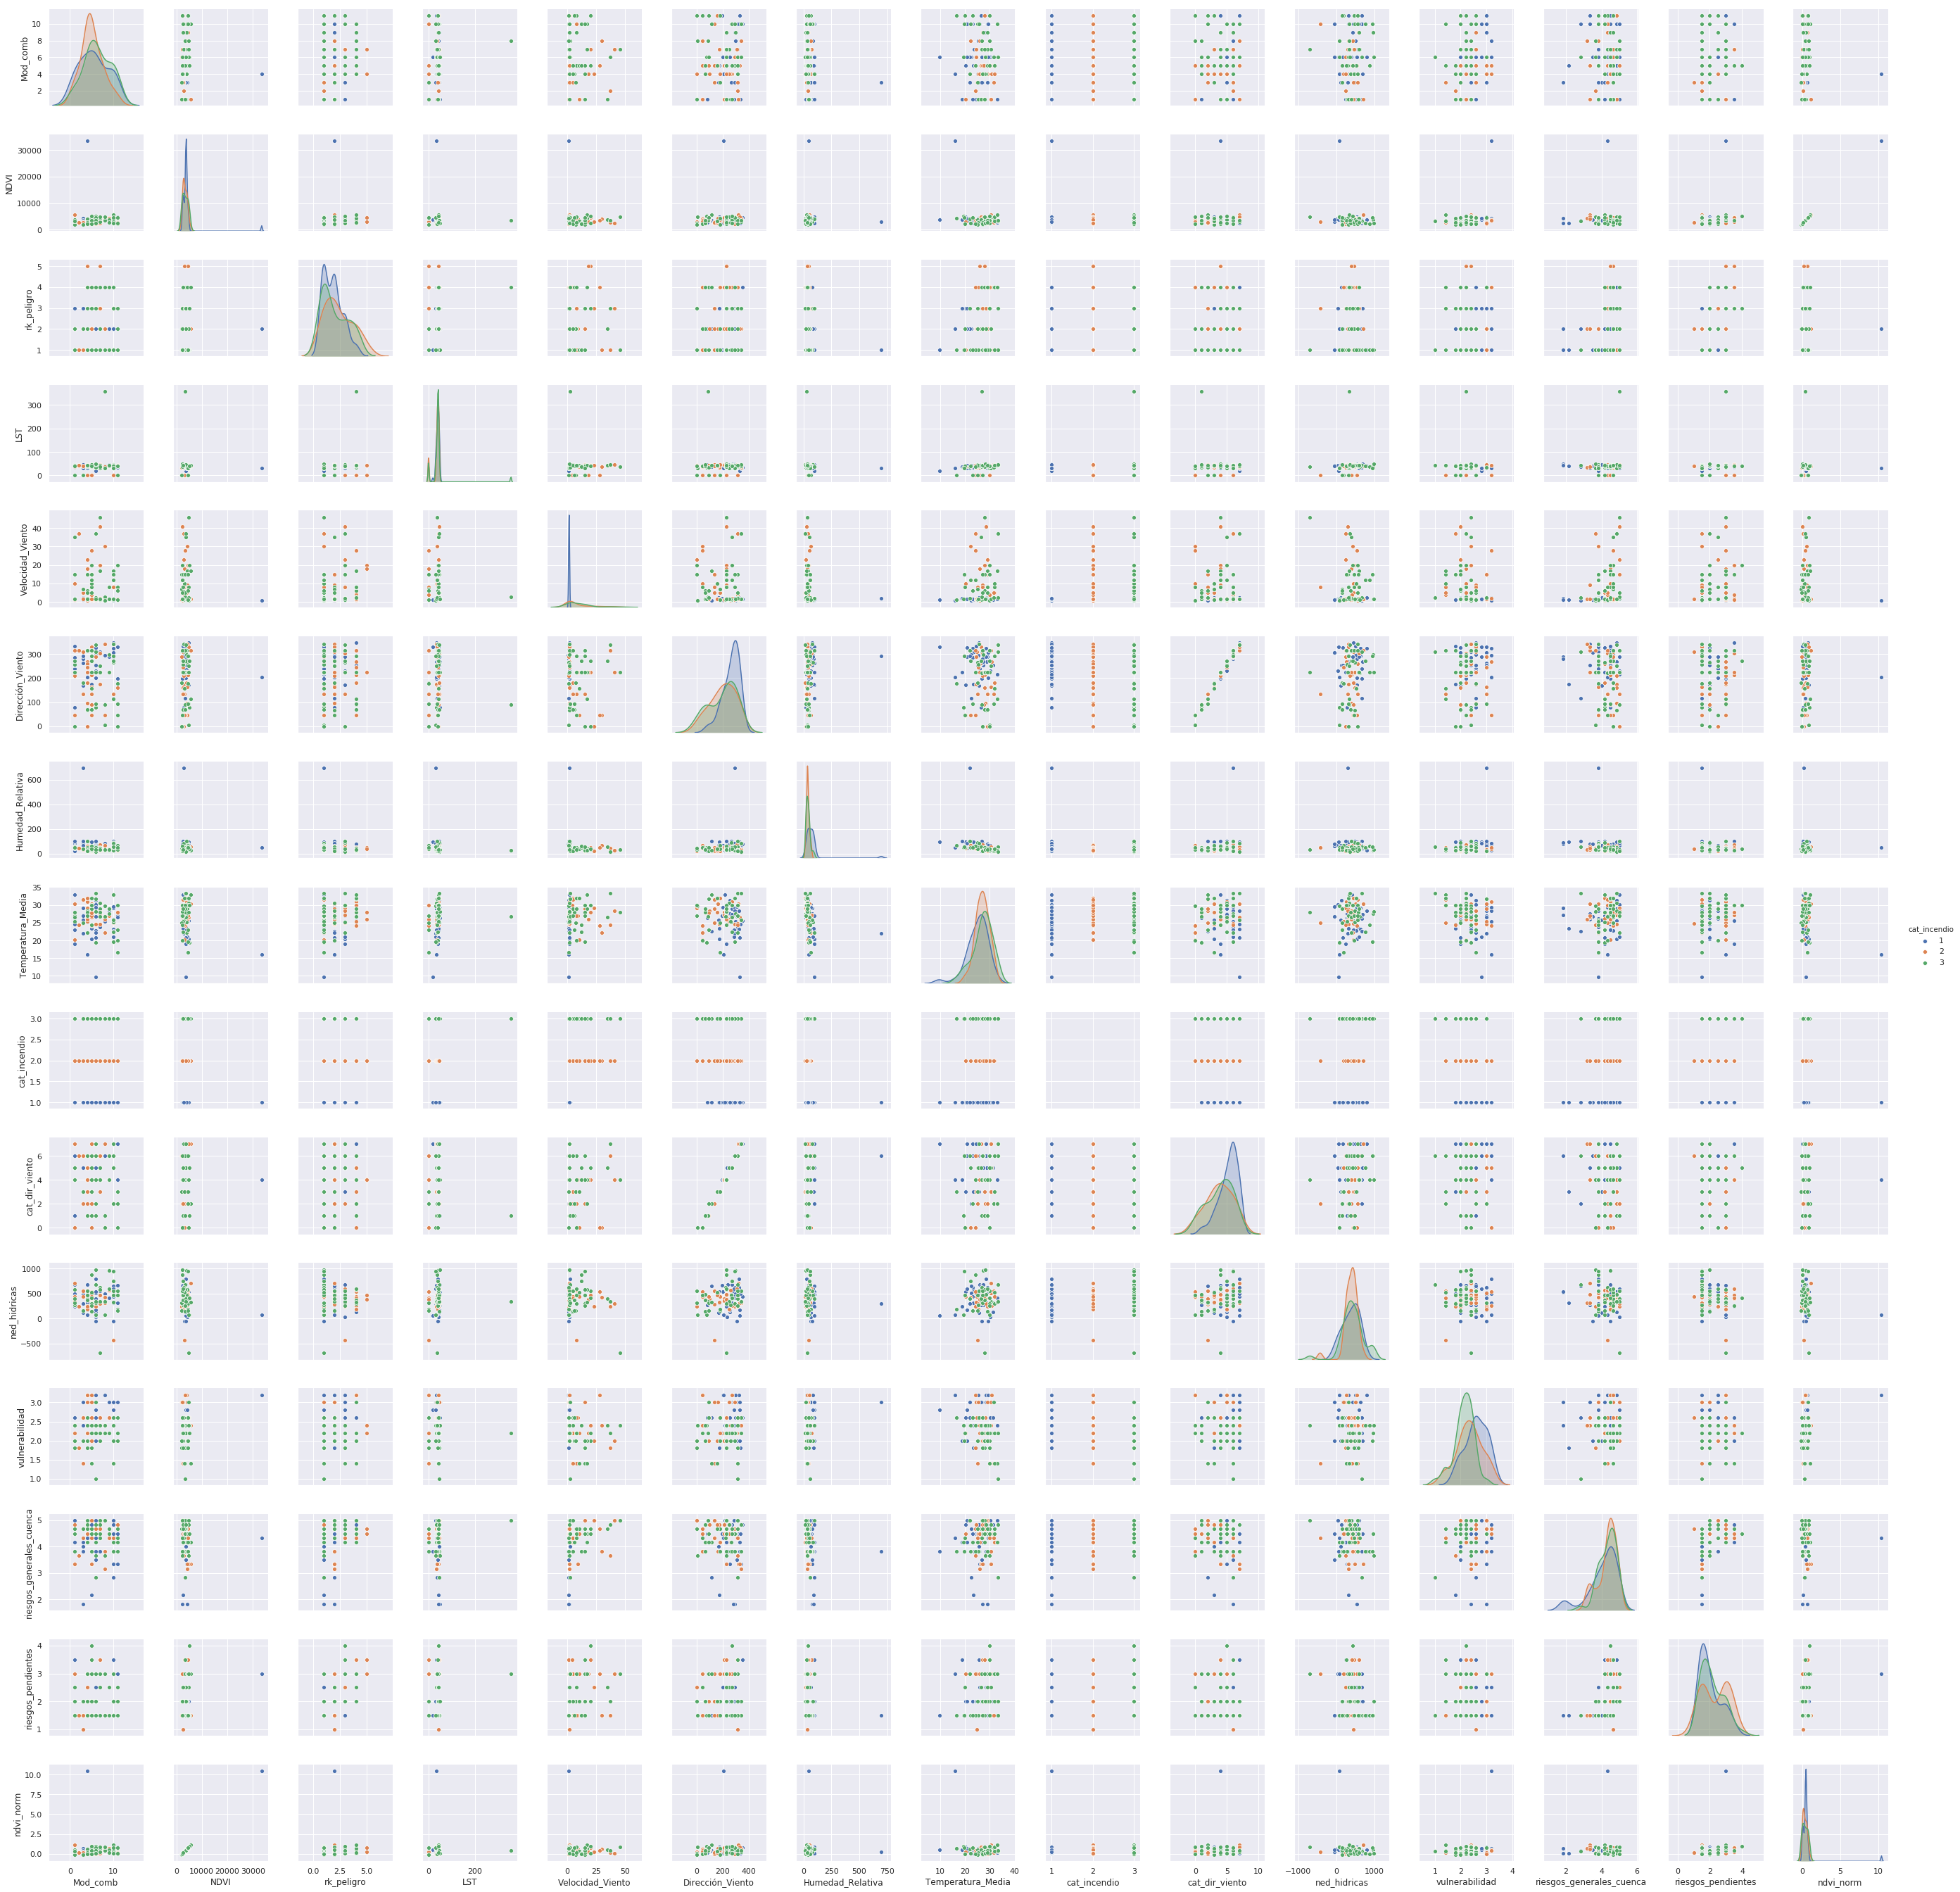

In [0]:
import seaborn as sns; sns.set()
sns.pairplot(df,hue="cat_incendio")

In [0]:
#Se separan las entradas de las salidas
    outputs = df1.iloc[:,6]
    data_=df1.drop(['cat_incendio'],axis=1)
    inputs = data_.iloc[:,:]
    Input_Data = inputs.values[:,:]
    Output_Data = list(outputs.values[:])



In [0]:
# Separacion muestra: entrenamiento y test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Input_Data,Output_Data,test_size=0.2)

In [0]:
# Normalizar valores antes de introducir en el modelo
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [0]:
### RANDOM FOREST ###

In [0]:
# Parámetros para optimizar el modelo de RF
criterion = ['gini','entropy']
n=[5,10,20,50]
depth=[2,3,5,8,10,30,100]
oob=True
#penalty=['l2','l1','elasticnet']
#activations = ['identity']#,'logistic','tanh','relu']
#solvers = ['lbfgs','adam']
#iters_VIU = [2000,3000]
param_grid = {'criterion': criterion,
              'n_estimators': n,
             'max_depth':depth}


In [45]:
# GridSearch con modelo RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
grid = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=1,cv=10,verbose=True)

# Entrenar modelo
grid.fit(X_train,np.ravel(y_train))

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:   12.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [46]:
#Cálculo del RMSE y R2
    
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    R2 = grid.score(X_test,np.ravel(y_test))
    params = grid.best_params_
    rmse = sqrt(mean_squared_error(np.ravel(y_test),grid.predict(X_test)))
    rmse = (rmse / np.mean(y_test))*100
    results1 = [R2,params,rmse]
    #Se guarda el modelo en el fichero AB.pkl
   # joblib.dump(grid.best_estimator_, 'Z:/ScriptsRafa/EUCA/entrenamiento_clas_esp_euca/clas_euca_bagging.pkl')
    pred1 = grid.predict(X_test)
    #print(outputs.columns[0])
    print (results1)
    print('--------------------')
    model_1 = grid.best_estimator_
    R2_v=[]


[0.5, {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 20}, 49.587383604650555]
--------------------


In [0]:
### MLP ###

In [0]:
# Parámetros para optimizar el modelo de MLP
parameter_grid_MLP = {
            'hidden_layer_sizes': [(10),(30),(50),(100),(10,10),(30,30),(50,50),(100,100)],
            'solver': ['lbfgs','sgd','adam'],
            'activation' : ['identity','logistic','tanh','relu'],
            'learning_rate': ['constant','adaptive'],
            'alpha': [0.0001,0.001,0.005,0.01]
            }

In [65]:
##MLP###
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

grid1 = GridSearchCV(MLPClassifier(early_stopping=True),param_grid=parameter_grid_MLP,cv=5,verbose=True,n_jobs=-2)
grid1.fit(X_train,np.ravel(y_train))
params= grid.best_params_
pred= grid1.predict(X_test)
score= grid.score(X_test, np.ravel(y_test))
mat= confusion_matrix(y_test,pred)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 3840 out of 3840 | elapsed:  3.0min finished


In [66]:
print(mat) # matriz de confusión

[[10  0  1]
 [ 2  1  2]
 [ 1  1  4]]


In [67]:
print(score) 

0.7272727272727273


In [0]:
## hacer curva ROC

In [0]:
#### XGBOOST ###

In [71]:

import xgboost as xgb
from scipy.stats import uniform, randint

xgb_model = xgb.XGBRegressor()
    
parameter_grid_XGBOOST = {
            "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
            }
    
    
grid2 = GridSearchCV(xgb_model, param_grid=parameter_grid_XGBOOST, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)
grid2.fit(X_train,np.ravel(y_train))
pred = grid2.predict(X_test)
score = grid2.score(X_test,np.ravel(y_test))
   
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

TypeError: ignored

In [0]:
### BAGGING ###

In [68]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


n=[10,50,70,80,100]
base= [DecisionTreeClassifier(),KNeighborsClassifier()]
param_grid = {'n_estimators': n,
                  'base_estimator':base}

grid = GridSearchCV(BaggingClassifier(),param_grid=param_grid,n_jobs=-2,cv=10,verbose=True)
    
grid.fit(X_train,np.ravel(y_train))
pred = grid.predict(X_test)
score = grid.score(X_test,np.ravel(y_test))
   
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[[7 2 2]
 [2 2 1]
 [0 0 6]]
0.6818181818181818


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    8.0s finished


In [0]:
### A PARTIR DE AQUI BORRAR!

In [0]:
# Cantidad de incendio por meses
print('fechaMonth', df.fechaMonth.value_counts(), sep='\n')

fechaMonth
7    44
8    34
6    18
9     7
5     5
4     1
2     1
Name: fechaMonth, dtype: int64


In [0]:
# Cambiamos la variable mes, a variable categórica

for col in ['mes']:
    df[col] = df[col].astype('category')

df.mes.dtype

CategoricalDtype(categories=[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12], ordered=False)

In [0]:
# Linealizamos la variable categórica (mes) y (año), usando one-hot-encoding.
# Realizamos la codificación

df_encoding = pd.get_dummies(df, columns = ['mes', 'año'])
df_encoding.head()

,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,...,año_2009,año_2010,año_2011,año_2012,año_2013,año_2014,año_2015,año_2016,año_2017,año_2018
0,30.392000,5.779,0.00,24.613001,0.190149,0.000000,0.809851,5,5,5,...,0,0,0,0,1,0,0,0,0,0
1,12.346000,4.312,6.47,1.564000,0.349263,0.524056,0.126681,3,4,5,...,0,0,0,1,0,0,0,0,0,0
2,13.000000,0.000,13.00,0.000000,0.000000,1.000000,0.000000,4,4,2,...,0,0,0,0,1,0,0,0,0,0
3,10.787000,0.000,0.00,10.787000,0.000000,0.000000,1.000000,5,4,2,...,0,0,0,0,0,0,0,0,0,1
4,40.383999,19.288,0.00,21.096001,0.477615,0.000000,0.522385,5,5,5,...,0,0,0,0,0,0,1,0,0,0


In [0]:
df_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 44 columns):
sup_quemad          67 non-null float64
sup_arb             67 non-null float64
sup_pastiz          67 non-null float64
sup_matorr          67 non-null float64
w_arb               67 non-null float64
w_pastiz            67 non-null float64
w_matorr            67 non-null float64
rk_Cuenc_F          67 non-null int64
rk_hist_Cu          67 non-null int64
rk_hist_us          67 non-null int64
rk_orograf          67 non-null int64
rk_peligro          67 non-null int64
rk_pte              67 non-null int64
vuln_equip          67 non-null int64
vuln_forve          67 non-null int64
vuln_infra          67 non-null int64
vuln_max            67 non-null int64
vuln_pathi          67 non-null int64
LST                 65 non-null float64
rk_combUSIF         67 non-null int64
rk_combCuencExtr    67 non-null int64
rk_combCuencSup     67 non-null int64
mes_1               67 non-null uint8
mes_2  

In [0]:
df_encoding.head()

,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,...,año_2009,año_2010,año_2011,año_2012,año_2013,año_2014,año_2015,año_2016,año_2017,año_2018
0,30.392000,5.779,0.00,24.613001,0.190149,0.000000,0.809851,5,5,5,...,0,0,0,0,1,0,0,0,0,0
1,12.346000,4.312,6.47,1.564000,0.349263,0.524056,0.126681,3,4,5,...,0,0,0,1,0,0,0,0,0,0
2,13.000000,0.000,13.00,0.000000,0.000000,1.000000,0.000000,4,4,2,...,0,0,0,0,1,0,0,0,0,0
3,10.787000,0.000,0.00,10.787000,0.000000,0.000000,1.000000,5,4,2,...,0,0,0,0,0,0,0,0,0,1
4,40.383999,19.288,0.00,21.096001,0.477615,0.000000,0.522385,5,5,5,...,0,0,0,0,0,0,1,0,0,0


In [0]:
df_encoding.describe(include='all')

,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,...,año_2009,año_2010,año_2011,año_2012,año_2013,año_2014,año_2015,año_2016,año_2017,año_2018
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,309.007809,163.127371,52.031702,93.848702,0.408739,0.231996,0.359265,4.074627,4.268657,3.746269,...,0.089552,0.029851,0.029851,0.104478,0.089552,0.074627,0.089552,0.134328,0.268657,0.059701
std,1133.840907,716.989224,182.544583,293.991057,0.331158,0.318100,0.300027,0.942489,0.770322,1.470346,...,0.287694,0.171460,0.171460,0.308188,0.287694,0.264772,0.287694,0.343578,0.446606,0.238721
min,10.020001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.470500,2.122500,0.000000,2.575000,0.068108,0.000000,0.077334,3.000000,4.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.314999,13.147000,4.800000,10.850000,0.367717,0.066222,0.368828,4.000000,4.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.950501,43.080999,14.168000,30.869500,0.678826,0.372577,0.537543,5.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,8160.500000,5501.629883,1205.410034,2016.250000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Análisis univariable: 'sup_quemad'

In [0]:
# Resumen de estadística descriptiva:

df_encoding['sup_quemad'].describe()

count      67.000000
mean      309.007809
std      1133.840907
min        10.020001
25%        17.470500
50%        39.314999
75%       100.950501
max      8160.500000
Name: sup_quemad, dtype: float64

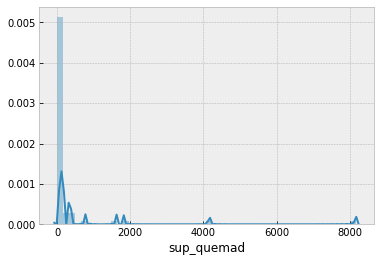

In [0]:
# Histograma:

sns.distplot(df_encoding['sup_quemad']);

Se puede observar que en la mayoría de los incendios, la superficie quemada se encuentra en alrededor de 101 hectáreas.

In [0]:
# Asimetría y curtosis:

print("Skewness: %f" % df_encoding['sup_quemad'].skew())
print("Kurtosis: %f" % df_encoding['sup_quemad'].kurt())

Skewness: 5.849747
Kurtosis: 37.312405


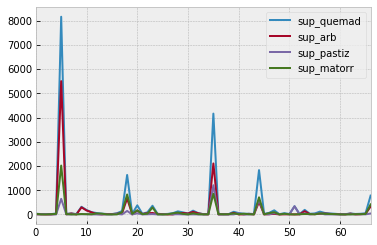

In [0]:
# Plotting superficie quemada, arborea, pastizal y matorral

df2 = df.loc[:,["sup_quemad","sup_arb","sup_pastiz","sup_matorr"]]
df2.plot()


En el gráfico anterior podemos observar que las 4 variables, están fuertemente correlacionadas. Para asegurarnos lo podemos ver en la correlación de las varibles que calcularemos a continuación.

Vemos la correlación entre las variables para confirmar la fuerte relación entre los distintos tipos de superficies quemadas.

Aqui tendriamos que plantear eliminar las variables, y quedarnos con la variable <b>sup_quemad</b>.

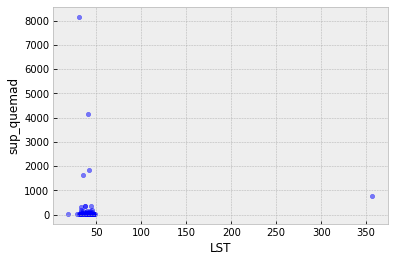

In [0]:
# Diagrama de dispersión LST/sup_quemad:

var = 'LST'
data = pd.concat([df_encoding['sup_quemad'], df_encoding[var]], axis=1)
data.plot.scatter(x=var, y='sup_quemad', alpha = 0.5);

Se puede apreciar un valor anómalo en <b>LST</b> (temperaturas Modis), hay un valor por encima de 350 que habría que eliminar.

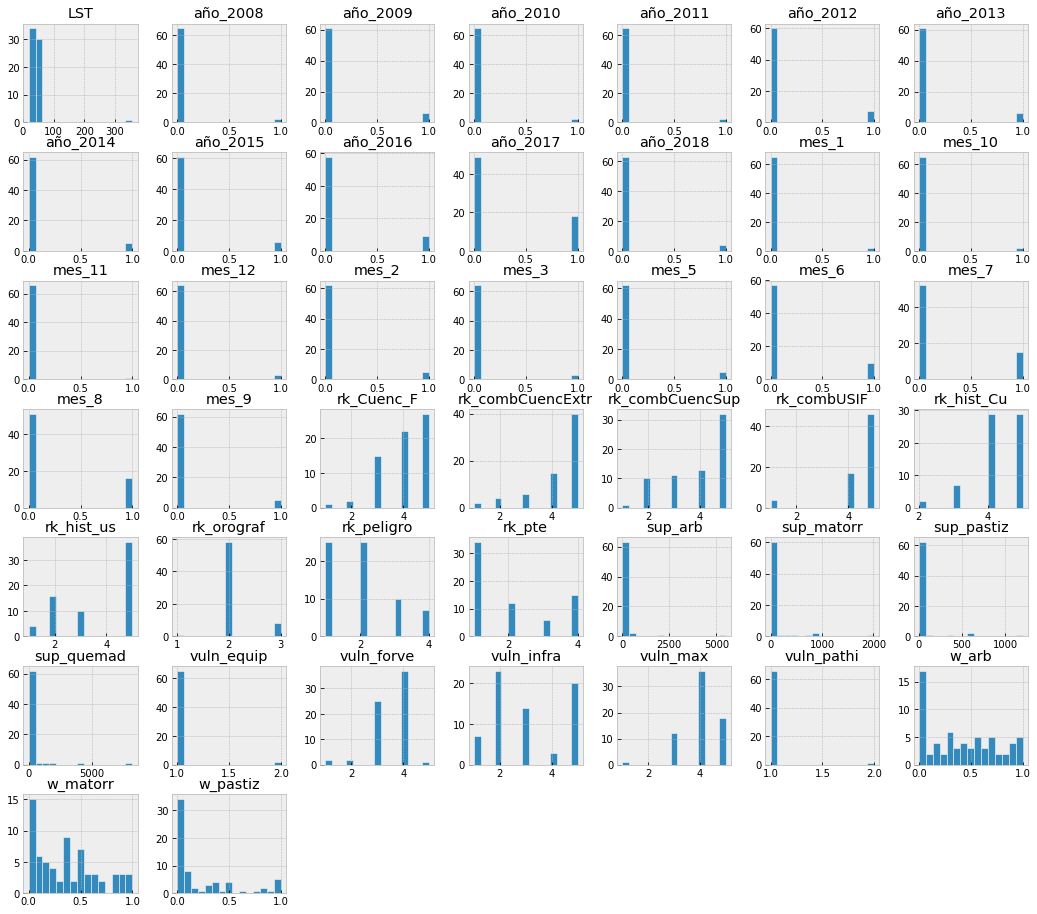

In [0]:
#visualizamos distribuciones
df_encoding.hist(bins=15, figsize=(18,16), ec='w')
plt.show()


Text(4800, 15, 'max: 8160.5')

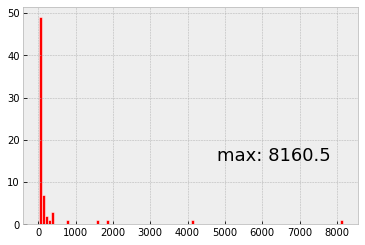

In [0]:
plt.hist(df_encoding.sup_quemad, ec='w', bins=100, color='red')
plt.text(4800,15, 'max: '+str(df_encoding.sup_quemad.max()), color='black', fontsize=18)


In [0]:
# Agrupamos las areas quemadas para una mejor comprensión

df_encoding['sup_quemad_cat'] = pd.cut(df_encoding['sup_quemad'], bins=[0,5, 10, 50, 100, 1100], include_lowest=True, 
                                 labels=['0-5','5-10', '10-50', '50-100', '>100'])
df_encoding.sup_quemad_cat.value_counts()

10-50     40
>100      13
50-100    10
5-10       0
0-5        0
Name: sup_quemad_cat, dtype: int64

In [0]:
# sup_quemad: área quemada total en hectáreas (ha), debería ser el atributo objetivo.
df_encoding.corr()

,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,...,año_2009,año_2010,año_2011,año_2012,año_2013,año_2014,año_2015,año_2016,año_2017,año_2018
sup_quemad,1.000000,0.985157,0.785015,0.966676,0.099558,-0.055326,-0.051229,0.184511,0.065214,-0.136264,...,-0.079869,-0.043777,-0.045787,-0.055518,-0.081175,-0.048952,-0.074119,-0.015721,0.258112,0.044963
sup_arb,0.985157,1.000000,0.688284,0.933294,0.133429,-0.073816,-0.069012,0.182629,0.035761,-0.147960,...,-0.069592,-0.037287,-0.039396,-0.057200,-0.068518,-0.051276,-0.066654,-0.042185,0.259511,0.031880
sup_pastiz,0.785015,0.688284,1.000000,0.728065,-0.000112,0.096681,-0.102382,0.057933,0.087888,-0.096724,...,-0.076633,-0.050070,-0.043267,0.005996,-0.086318,-0.071413,-0.070637,0.045693,0.218864,-0.019376
sup_matorr,0.966676,0.933294,0.728065,1.000000,0.058626,-0.093386,0.034302,0.230236,0.109724,-0.104627,...,-0.090727,-0.046808,-0.053644,-0.078341,-0.092369,-0.019399,-0.079442,0.013877,0.226670,0.107690
w_arb,0.099558,0.133429,-0.000112,0.058626,1.000000,-0.573548,-0.495662,0.201138,0.173999,-0.011428,...,-0.188495,0.000335,-0.115375,0.023975,0.076484,-0.015969,-0.055633,-0.099438,0.065958,0.075766
w_pastiz,-0.055326,-0.073816,0.096681,-0.093386,-0.573548,1.000000,-0.427178,-0.438960,-0.060905,0.072169,...,0.310687,-0.122887,0.137843,0.020237,-0.064896,-0.056638,-0.086476,-0.107730,0.122109,-0.158593
w_matorr,-0.051229,-0.069012,-0.102382,0.034302,-0.495662,-0.427178,1.000000,0.243394,-0.127480,-0.063902,...,-0.121349,0.129919,-0.018801,-0.047919,-0.015614,0.077676,0.153089,0.223975,-0.202266,0.084518
rk_Cuenc_F,0.184511,0.182629,0.057933,0.230236,0.201138,-0.438960,0.243394,1.000000,0.305875,-0.117331,...,-0.025020,0.173526,-0.295274,-0.340229,0.030859,0.038061,0.086738,0.062154,-0.012357,0.181925
rk_hist_Cu,0.065214,0.035761,0.087888,0.109724,0.173999,-0.060905,-0.127480,0.305875,1.000000,0.248376,...,-0.041837,0.053077,0.053077,-0.183845,-0.178573,0.123072,0.231635,0.033323,-0.168934,0.158638
rk_hist_us,-0.136264,-0.147960,-0.096724,-0.104627,-0.011428,0.072169,-0.063902,-0.117331,0.248376,1.000000,...,-0.196199,-0.029601,0.150698,-0.040922,-0.124562,-0.028463,0.018711,0.158467,0.151527,-0.128855


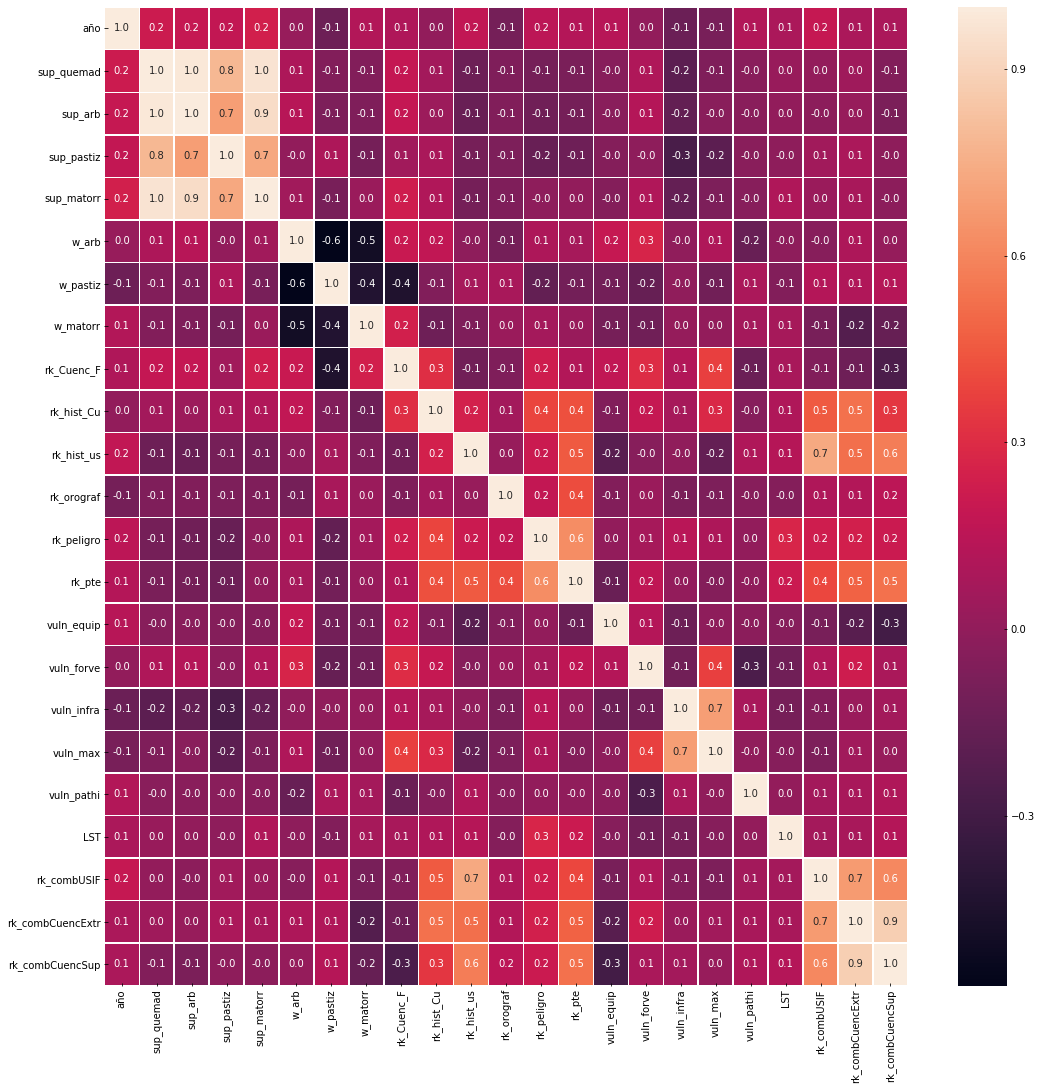

In [0]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [0]:
corr_matrix = df_encoding.corr(method='spearman')
corr_matrix

,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,...,año_2009,año_2010,año_2011,año_2012,año_2013,año_2014,año_2015,año_2016,año_2017,año_2018
sup_quemad,1.000000,0.728436,0.429667,0.715941,0.175958,-0.051306,0.153539,0.199243,0.103892,0.071807,...,-0.270286,-0.058957,-0.181406,0.123633,-0.294612,0.108664,-0.081086,0.158426,0.200229,0.127037
sup_arb,0.728436,1.000000,0.130791,0.464802,0.712429,-0.305635,-0.098620,0.331519,0.265331,0.030519,...,-0.235823,-0.050030,-0.131897,0.012652,-0.153149,0.108975,-0.073186,0.011349,0.165881,0.171501
sup_pastiz,0.429667,0.130791,1.000000,0.187386,-0.325470,0.829840,-0.225933,-0.245991,0.014758,0.138057,...,0.053223,-0.171737,0.045796,-0.025479,-0.296137,-0.019277,-0.099622,0.018283,0.338455,0.011513
sup_matorr,0.715941,0.464802,0.187386,1.000000,-0.124213,-0.218222,0.721047,0.294845,0.119130,-0.015843,...,-0.200180,0.018156,-0.113474,0.005050,-0.197474,0.129330,0.075744,0.174415,0.048792,0.156484
w_arb,0.175958,0.712429,-0.325470,-0.124213,1.000000,-0.492393,-0.413031,0.181236,0.202334,-0.021274,...,-0.192455,0.022741,-0.095512,0.015182,0.065055,0.005891,-0.032528,-0.102138,0.054130,0.063701
w_pastiz,-0.051306,-0.305635,0.829840,-0.218222,-0.492393,1.000000,-0.356128,-0.439236,-0.079017,0.165667,...,0.241574,-0.162594,0.196945,-0.030578,-0.248398,-0.081564,-0.096903,-0.031999,0.263758,-0.126651
w_matorr,0.153539,-0.098620,-0.225933,0.721047,-0.413031,-0.356128,1.000000,0.207439,-0.041589,-0.032505,...,-0.132557,0.113479,0.004539,-0.060608,-0.027052,0.105820,0.197482,0.185748,-0.169038,0.071725
rk_Cuenc_F,0.199243,0.331519,-0.245991,0.294845,0.181236,-0.439236,0.207439,1.000000,0.314435,-0.176462,...,-0.043021,0.192496,-0.262276,-0.293172,0.010038,0.074793,0.063098,0.034823,-0.037875,0.191834
rk_hist_Cu,0.103892,0.265331,0.014758,0.119130,0.202334,-0.079017,-0.041589,0.314435,1.000000,0.264934,...,-0.059093,0.044618,0.044618,-0.144803,-0.125572,0.118786,0.251143,0.019792,-0.224590,0.167356
rk_hist_us,0.071807,0.030519,0.138057,-0.015843,-0.021274,0.165667,-0.032505,-0.176462,0.264934,1.000000,...,-0.190161,-0.032661,0.150744,-0.040535,-0.118289,-0.027658,0.019465,0.155470,0.148541,-0.131729


In [0]:
corr_matrix.sup_quemad.sort_values(ascending=False)

sup_quemad          1.000000
sup_arb             0.728436
sup_matorr          0.715941
sup_pastiz          0.429667
mes_8               0.202739
año_2017            0.200229
rk_Cuenc_F          0.199243
rk_combUSIF         0.183109
w_arb               0.175958
vuln_forve          0.168549
mes_11              0.165488
rk_combCuencExtr    0.164465
mes_3               0.164197
año_2016            0.158426
w_matorr            0.153539
rk_pte              0.145760
año_2018            0.127037
año_2012            0.123633
año_2014            0.108664
rk_hist_Cu          0.103892
rk_combCuencSup     0.081239
vuln_equip          0.077098
rk_hist_us          0.071807
rk_peligro          0.068437
mes_5               0.046990
mes_2               0.035242
mes_12             -0.007464
w_pastiz           -0.051306
año_2010           -0.058957
rk_orograf         -0.062226
LST                -0.071024
mes_7              -0.079613
año_2015           -0.081086
año_2008           -0.081633
vuln_pathi    

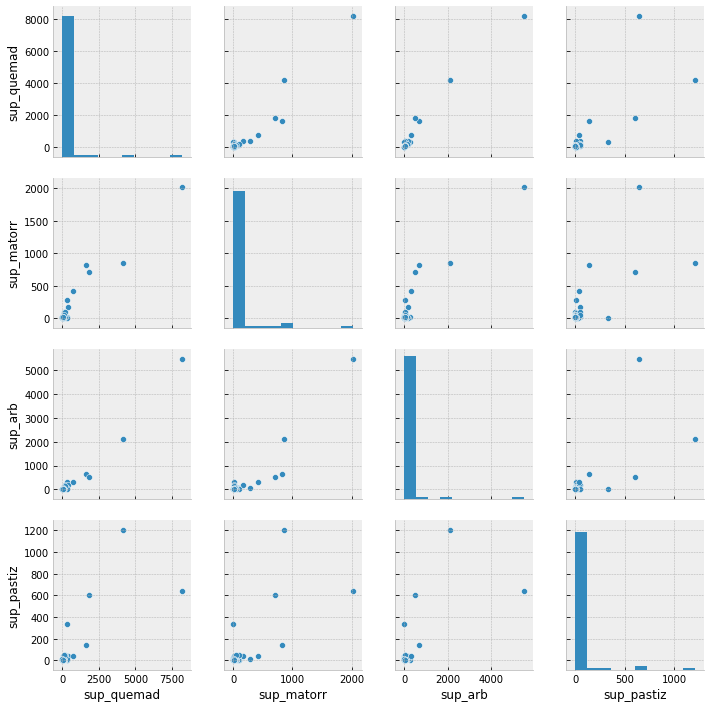

In [0]:
# visualizando las relaciones de los atributos mas relacionados
attributes = ['sup_quemad', 'sup_matorr', 'sup_arb', 'sup_pastiz']
sns.pairplot(df_encoding[attributes])
plt.show()

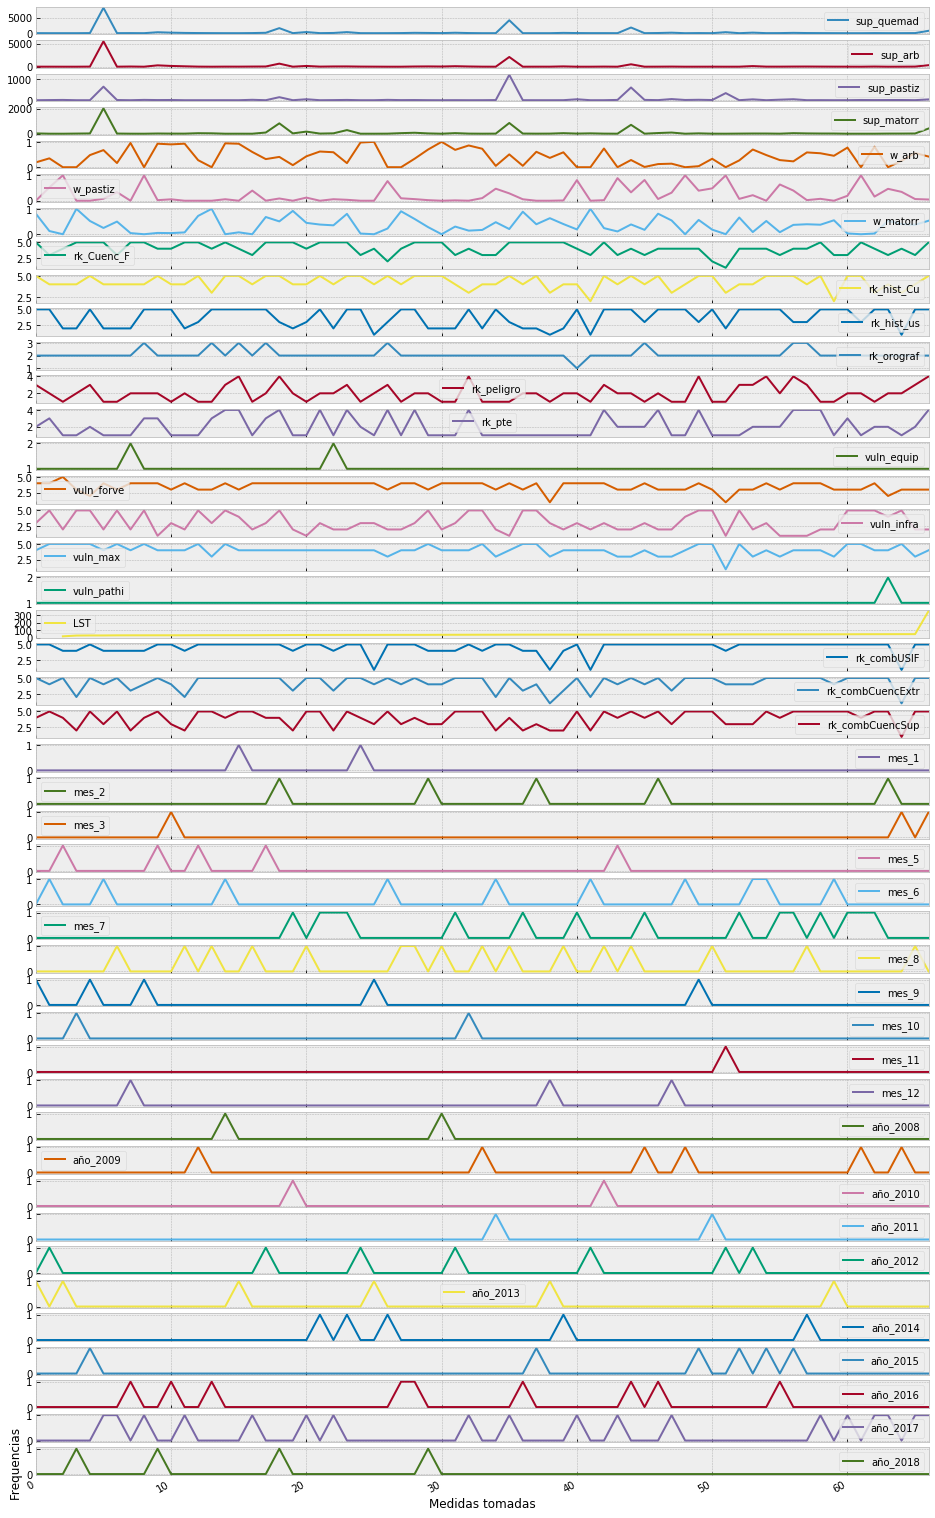

In [0]:
df_encoding.plot(subplots = True, figsize = (16,30))
plt.xlabel('Medidas tomadas') 
plt.ylabel('Frequencias')
plt.show()